In [1]:
import io
import os
import sys
import csv
import gzip
import time
import multiprocessing
import resource
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('scripts/')
import lcwgSus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

/gpfs3/well/band/users/rbx225/GAMCC


# Loat test data

In [ ]:
chromosomes = [i for i in range(1,23)]
vcfs = ["/well/band/users/rbx225/test_files/lcwgs/chr" + str(i) + ".vcf.gz" for i in chromosomes]
mafs = ["/well/band/users/rbx225/test_files/maf/maf_chr" + str(i) + ".txt" for i in chromosomes]
vcf = lcwgSus.multi_parse_vcf(chromosomes, vcfs)
af = lcwgSus.multi_read_af(chromosomes, mafs)
chip = lcwgSus.read_vcf("/well/band/users/rbx225/test_files/chip/GAM013489.vcf.gz")
chip = lcwgSus.drop_cols(chip, drop_lst = ['id', 'qual', 'filter','info','format'])

In [65]:
# chromosomes = [22]
# vcf1 = ["/well/band/users/rbx225/GAMCC_vcfs/oneKG_ggvp/check.vcf.gz"]
# vcf2 = ["/well/band/users/rbx225/GAMCC_vcfs/oneKG/check.vcf.gz"]
# mafs = ["/well/band/users/rbx225/recyclable_files/gnomAD/AFs/afr/gnomAD_MAF_afr_chr22.txt"]
# vcf1 = lcwgSus.multi_parse_vcf(chromosomes, vcf1)
# vcf2 = lcwgSus.multi_parse_vcf(chromosomes, vcf2)

# print(vcf1[vcf1['GT'].isin(['0|0'])].DS.mean())
# print(vcf1[vcf1['GT'].isin(['1|0', '0|1'])].DS.mean())
# print(vcf1[vcf1['GT'].isin(['1|1'])].DS.mean())
# print(vcf2[vcf2['GT'].isin(['0|0'])].DS.mean())
# print(vcf2[vcf2['GT'].isin(['1|0', '0|1'])].DS.mean())
# print(vcf2[vcf2['GT'].isin(['1|1'])].DS.mean())

In [76]:
print(vcf1[vcf1['GT'].isin(['0|0'])].DS.mean())
print(vcf1[vcf1['GT'].isin(['1|0', '0|1'])].DS.mean())
print(vcf1[vcf1['GT'].isin(['1|1'])].DS.mean())
print(vcf2[vcf2['GT'].isin(['0|0'])].DS.mean())
print(vcf2[vcf2['GT'].isin(['1|0', '0|1'])].DS.mean())
print(vcf2[vcf2['GT'].isin(['1|1'])].DS.mean())

0.0349618221682823
0.9133950109553112
1.950930701844819
0.0038675884128930027
0.9745697649133903
1.9775398954946861


# plot_info_vs_af

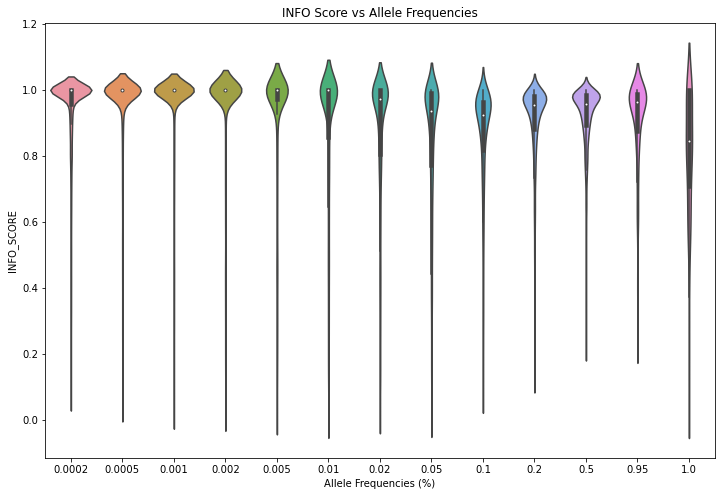

In [3]:
lcwgSus.plot_info_vs_af(vcf, af)

# sequencing_skew

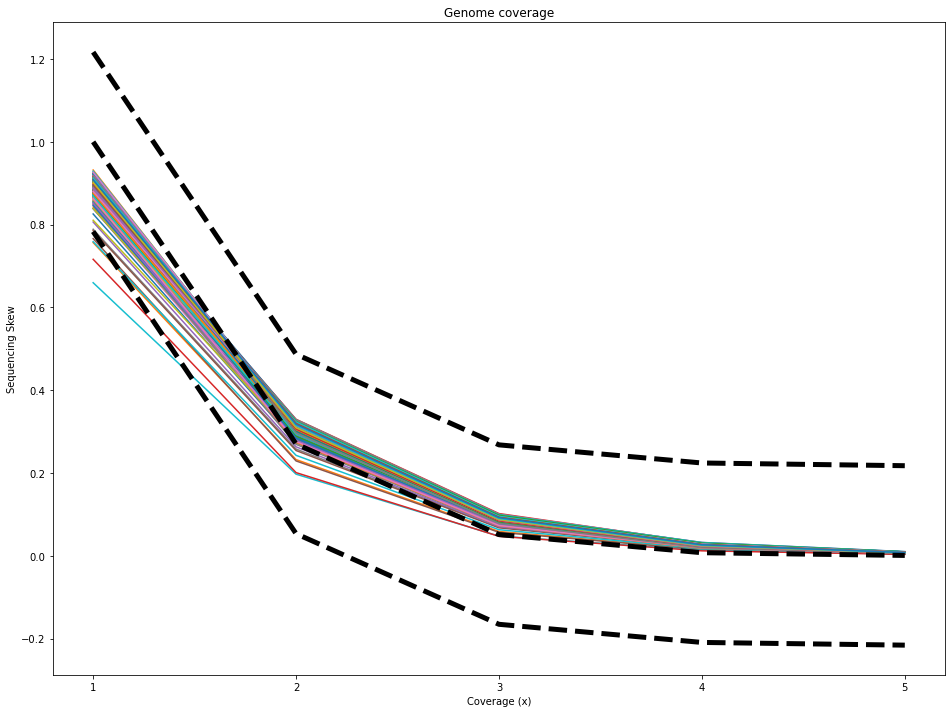

In [3]:
x = pd.read_csv('../samples.tsv', header = None, names = ['Code'])
samples = x['Code'].to_list()
ary_lst = []
for i in samples:
    ary_lst.append(np.loadtxt("../results/coverage/subsampled_bedgraphs/" + i + "_cumsum_ary.txt"))
lcwgSus.plot_sequencing_skew(ary_lst, 0.6, save_fig = True, outdir = '../graphs/') 

# ChIP data

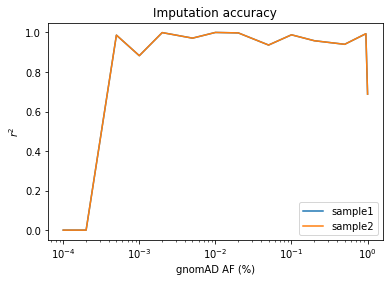

In [4]:
r2 = lcwgSus.calculate_imputation_accuracy(vcf, chip, af)
x = [r2,r2]
lcwgSus.plot_imputation_accuracy(x, label = ['sample1', 'sample2'])

# Check allele frequencies

In [2]:
chip_af = pd.read_csv('/well/band/users/rbx225/test_files/vcf_dfs/chip_df.tsv', sep = '\t')
chip_af = chip_af.drop(columns = ['ID', 'QUAL','FILTER', 'INFO', 'FORMAT'])
chip_af = chip_af.rename(columns = {'#CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
chip_af = lcwgSus.calculate_af(chip_af)
quilt_af = pd.read_csv('/well/band/users/rbx225/test_files/vcf_dfs/quilt_df.tsv', sep = '\t', usecols = ['#CHROM', 'POS', 'REF', 'ALT', 'INFO'])
quilt_af = quilt_af.rename(columns = {'#CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt', 'INFO': 'info'})
quilt_af = lcwgSus.extract_info(quilt_af, info_cols = ['EAF'])
quilt_af['chr'] = quilt_af['chr'].str.replace('chr', '').astype(int)
quilt_af = quilt_af.rename(columns = {'EAF': 'prop'})
lcwgSus.plot_afs(chip_af, quilt_af, save_fig = True)

# plot imputation accuracy

In [47]:
# To be restructured later together with pipelines
linker = pd.read_csv('data/metadata/sample_linker.csv', sep = ',')
# def read_r2(samples, indir):
ggvp = []
onekg = []
for i in samples:
    file_count = len([f for f in os.listdir("/well/band/users/rbx225/GAMCC/results/imputation/tmp/"+i+"/")])
    if file_count == 2:
        df1 = pd.read_csv("results/imputation/tmp/"+i+"/oneKG_ggvp_imputation_accuracy.csv", sep = '\t', dtype = {
            'Unnamed: 0': str,
            'Imputation Accuracy': float,
            'Bin Count': str
        }).iloc[2:,:]
        df1['panel'] = 'oneKG_ggvp'
        df1['Bin Count'] = i
        df1.columns = ['AF', 'corr', 'sample', 'panel']
        df1['AF'] = df1['AF'].shift(1).fillna('0') + '-' + df1['AF']
        df1['AF'] = df1['AF'].astype("category")
        ggvp.append(df1)
        df2 = pd.read_csv("results/imputation/tmp/"+i+"/oneKG_imputation_accuracy.csv", sep = '\t', dtype = {
            'Unnamed: 0': str,
            'Imputation Accuracy': float,
            'Bin Count': str
        }).iloc[2:,:]
        df2['panel'] = 'oneKG'
        df2['Bin Count'] = i
        df2.columns = ['AF', 'corr', 'sample', 'panel']
        df2['AF'] = df2['AF'].shift(1).fillna('0') + '-' + df2['AF']
        df2['AF'] = df2['AF'].astype("category")
        onekg.append(df2)
res = pd.concat(ggvp + onekg).reset_index(drop = True)
res.head()

,AF,corr,sample,panel
0,0-0.0005,0.724394,IDT0673,oneKG_ggvp
1,0.0005-0.001,0.776280,IDT0673,oneKG_ggvp
2,0.001-0.002,0.717311,IDT0673,oneKG_ggvp
3,0.002-0.005,0.623582,IDT0673,oneKG_ggvp
4,0.005-0.01,0.718488,IDT0673,oneKG_ggvp


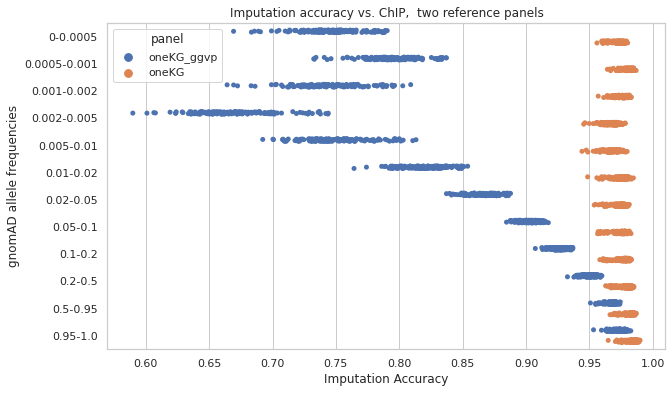

In [78]:
sns.set(style="whitegrid")
plt.figure(figsize = (10,6))
sns.stripplot(data=res[~res['sample'].isin(['IDT0669', 'IDT0595', 'IDT0693'])], x="corr", y="AF", hue="panel", dodge=True)
plt.xlabel('Imputation Accuracy')
plt.ylabel('gnomAD allele frequencies')
plt.title('Imputation accuracy vs. ChIP,  two reference panels')
plt.savefig('graphs/imputation_vs_chip.png', bbox_inches = "tight", dpi=300)

In [4]:
chromosomes = [i for i in range(1,23)]
vcfs = ["/well/band/users/rbx225/debug/chr" + str(i) + ".vcf.gz" for i in chromosomes]
mafs = ["/well/band/users/rbx225/GAMCC/data/gnomAD_MAFs/gnomAD_MAF_afr_chr" + str(i) + ".txt" for i in chromosomes]
chip = "/well/band/users/rbx225/debug/chip.vcf.gz"
MAF_ary = np.array([0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95, 1])

vcf = lcwgSus.multi_parse_vcf(chromosomes, vcfs)
# af = lcwgSus.multi_read_af(chromosomes, mafs)
chip = lcwgSus.read_vcf(chip)
chip = lcwgSus.drop_cols(chip, drop_lst = ['id', 'qual', 'filter','info','format'])
# r2 = lcwgSus.calculate_imputation_accuracy(vcf, chip, af)
# r2.to_csv(output.r2, sep=',', mode='a')

Process Process-25:
Process Process-26:
Traceback (most recent call last):
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs3/well/band/users/rbx225/GAMCC/scripts/lcwgSus.py", line 75, in read_af
    df = pd.read_csv(file, header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'MAF'],
Traceback (most recent call last):
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
Process Process-27:
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 680, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/apps/eb/2020b/skylake/

  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/common.py", line 789, in get_handle
    handle = open(
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 933, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/gpfs3/well/band/users/rbx225/GAMCC/scripts/lcwgSus.py", line 75, in read_af
    df = pd.read_csv(file, header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'MAF'],
FileNotFoundError: [Errno 2] No such file or directory: '/well/band/users/rbx225/GAMCC/data/gnomAD_MAFs/gnomAD_MAF_afr_chr4txt'
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1217, in _make_engine
    self.handles = get_handle(  # type: ignore[call-overload]
Traceback (most recent call last):
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/util/_decor

  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/common.py", line 789, in get_handle
    handle = open(
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/well/band/users/rbx225/GAMCC/data/gnomAD_MAFs/gnomAD_MAF_afr_chr9txt'
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 575, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/gpfs3/well/band/users/rbx225/GAMCC/scripts/lcwgSus.py", line 75, in read_af
    df = pd.read_csv(file, header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'MAF'],
  File "/apps/eb/2020b/skylake/software/A

  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1217, in _make_engine
    self.handles = get_handle(  # type: ignore[call-overload]
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 680, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/common.py", line 789, in get_handle
    handle = open(
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 575, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
Traceback (most recent call last):
FileNotFoundError: [Errno 2] No such file or directory: '/well/ba

  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 933, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1217, in _make_engine
    self.handles = get_handle(  # type: ignore[call-overload]
  File "/gpfs3/well/band/users/rbx225/GAMCC/scripts/lcwgSus.py", line 75, in read_af
    df = pd.read_csv(file, header = None, sep = '\t', names = ['chr', 'pos', 'ref', 'alt', 'MAF'],
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/pandas/io/common.py", line 789, in get_handle
    handle = open(
Traceback (most recent call last):
  File "/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python

IndexError: list index out of range

In [13]:
r2 = lcwgSus.calculate_imputation_accuracy(vcf, chip, af)

In [10]:
res = pd.merge(vcf, chip, on = ['chr', 'pos', 'ref', 'alt'], how = 'inner')
res

,chr,pos,ref,alt,EAF,INFO_SCORE,GT,GP,DS,call
0,1,784860,T,C,0.93698,0.96689,1|1,"0,0.002,0.998",1.998,1/1
1,1,785910,G,C,0.01980,0.88125,0|0,"0.998,0.002,0",0.002,0/0
2,1,788538,G,A,0.10770,0.97114,0|0,"0.998,0.002,0",0.002,0/0
3,1,818725,C,T,0.01737,0.86779,0|0,"0.998,0.002,0",0.002,0/0
4,1,819249,A,G,0.01777,0.87254,0|0,"0.998,0.002,0",0.002,0/0
...,...,...,...,...,...,...,...,...,...,...
748756,22,50749854,G,A,0.05963,0.95706,1|0,"0.001,0.998,0.001",1.000,0/1
748757,22,50749890,T,G,0.01554,0.93158,0|0,"0.998,0.002,0",0.002,0/0
748758,22,50770140,G,T,0.27513,0.97522,0|0,"0.998,0.002,0",0.002,0/0
748759,22,50777904,G,A,0.03906,0.94006,0|0,"0.998,0.002,0",0.002,0/0


In [36]:
r2

,Imputation Accuracy,Bin Count
MAF,,
0.0001,0.000000,0.0
0.0002,0.000000,0.0
0.0005,0.973785,98110.0
0.0010,0.980880,34290.0
0.0020,0.974370,37921.0
0.0050,0.973798,41939.0
0.0100,0.978367,26994.0
0.0200,0.982512,27795.0
0.0500,0.978544,48224.0


In [25]:
res['genotype'] = res.apply(lcwgSus.get_genotype, axis = 1)
res

,chr,pos,ref,alt,EAF,INFO_SCORE,GT,GP,DS,call,genotype
0,1,784860,T,C,0.93698,0.96689,1|1,"0,0.002,0.998",1.998,1/1,2.0
1,1,785910,G,C,0.01980,0.88125,0|0,"0.998,0.002,0",0.002,0/0,0.0
2,1,788538,G,A,0.10770,0.97114,0|0,"0.998,0.002,0",0.002,0/0,0.0
3,1,818725,C,T,0.01737,0.86779,0|0,"0.998,0.002,0",0.002,0/0,0.0
4,1,819249,A,G,0.01777,0.87254,0|0,"0.998,0.002,0",0.002,0/0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
748756,22,50749854,G,A,0.05963,0.95706,1|0,"0.001,0.998,0.001",1.000,0/1,1.0
748757,22,50749890,T,G,0.01554,0.93158,0|0,"0.998,0.002,0",0.002,0/0,0.0
748758,22,50770140,G,T,0.27513,0.97522,0|0,"0.998,0.002,0",0.002,0/0,0.0
748759,22,50777904,G,A,0.03906,0.94006,0|0,"0.998,0.002,0",0.002,0/0,0.0


In [42]:
def calculate_imputation_accuracy(df, 
                                  MAF_ary = np.array([0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.95, 1]),
                                 how = 'left'):
    r2 = np.zeros((2, np.size(MAF_ary) - 1))
    for i in range(r2.shape[1]):
        tmp = df[(MAF_ary[i+1] > df['EAF']) & (df['EAF'] > MAF_ary[i])]
        if tmp.shape[0] == 0:
            r2[0,i] = 0
        else:
            r2[0, i] = np.corrcoef(tmp['DS'].values, tmp['genotype'].values)[0,1]**2
        r2[1, i] = int(tmp.shape[0])
        
    r2_df = pd.DataFrame(r2.T, columns = ['Imputation Accuracy','Bin Count'], index = MAF_ary[1:])
    r2_df.index.name = 'MAF'
    return r2_df

In [132]:
sample_linker = pd.read_table("data/metadata/sample_linker.csv", sep = ',')
sample_linker = sample_linker[sample_linker['Chip_Name'].isin(chip_samples)].Seq_Name.to_list()
sample_linker

['IDT0673',
 'IDT0505',
 'IDT0485',
 'IDT0506',
 'IDT0508',
 'IDT0509',
 'IDT0510',
 'IDT0513',
 'IDT0765',
 'IDT0766',
 'IDT0767',
 'IDT0675',
 'IDT0514',
 'IDT0676',
 'IDT0677',
 'IDT0678',
 'IDT0679',
 'IDT0515',
 'IDT0516',
 'IDT0680',
 'IDT0517',
 'IDT0518',
 'IDT0732',
 'IDT0519',
 'IDT0520',
 'IDT0733',
 'IDT0521',
 'IDT0768',
 'IDT0522',
 'IDT0523',
 'IDT0581',
 'IDT0734',
 'IDT0593',
 'IDT0524',
 'IDT0719',
 'IDT0605',
 'IDT0682',
 'IDT0683',
 'IDT0525',
 'IDT0617',
 'IDT0526',
 'IDT0742',
 'IDT0629',
 'IDT0527',
 'IDT0528',
 'IDT0529',
 'IDT0531',
 'IDT0532',
 'IDT0641',
 'IDT0684',
 'IDT0533',
 'IDT0534',
 'IDT0486',
 'IDT0685',
 'IDT0535',
 'IDT0536',
 'IDT0537',
 'IDT0538',
 'IDT0687',
 'IDT0653',
 'IDT0540',
 'IDT0665',
 'IDT0582',
 'IDT0541',
 'IDT0487',
 'IDT0542',
 'IDT0735',
 'IDT0543',
 'IDT0594',
 'IDT0688',
 'IDT0606',
 'IDT0689',
 'IDT0690',
 'IDT0618',
 'IDT0544',
 'IDT0691',
 'IDT0693',
 'IDT0630',
 'IDT0694',
 'IDT0695',
 'IDT0696',
 'IDT0698',
 'IDT0642',
 'ID

In [128]:
chip_samples = pd.read_table("chip.tsv", header = None).loc[:, 0].to_list()

In [75]:
np.corrcoef(tmp[tmp['genotype'] == 0]['DS'].values, tmp[tmp['genotype'] == 0]['genotype'].values)[0,1]**2

/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/apps/eb/2020b/skylake/software/Anaconda3/2022.05/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan

In [120]:
tmp[tmp['DS'] == 0.002]

,chr,pos,ref,alt,EAF,INFO_SCORE,GT,GP,DS,call,genotype
20,1,874376,G,A,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
40,1,931771,G,A,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
42,1,935749,C,T,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
46,1,945623,G,A,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
54,1,961629,A,G,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
748635,22,50478625,G,T,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
748662,22,50522936,G,A,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
748702,22,50605304,C,T,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0
748705,22,50610789,C,T,0.001,1.0,0|0,"0.998,0.002,0",0.002,0/0,0.0


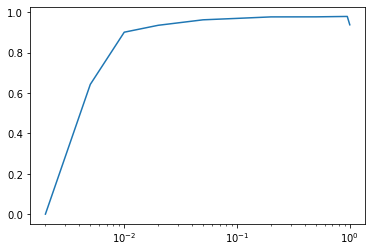

In [53]:
plt.plot(r2alt.index[4:], r2alt['Imputation Accuracy'].values[4:])
plt.xscale('log')